## Hierarchical Bayesian Modeling to assess tribal knowledge

In this analysis, we aim to develop a methodology and data-driven metric to identify potential technological risks within an organization's coding practices. We will explore the utilisation of programming languages across various projects and repositories, mirroring those found in code repositories such as GitHub. Our approach employs Hierarchical Bayesian Modelling (HBM) for multi-level data analysis, with a keen focus on the effects of programming languages within individual repositories.

While our primary interest lies in understanding language effects at the repository level, we also place significant emphasis on the aggregate usage of languages organisation-wide. This dual focus allows us to capture not only repository-specific variances but also overarching language trends, thereby providing a nuanced "risk" metric for Enterprise Architecture. Such a metric enables organisations to identify potential knowledge silos, thereby informing strategic decisions aimed at enhancing project continuity and organisational adaptability.

By analysing language usage across different organisational strata and integrating measures of uncertainty, HBM aims to expose pockets of siloed tribal knowledge. While initially focusing on language use, this methodology can be expanded to include other metrics, such as the number of commits, time since the last commit, total commits, and more. This approach is crucial for unveiling hidden risks within the architectural framework by uncovering potential vulnerabilities. It facilitates a comparison of language usage at the repository level against broader organisational patterns, offering insights into scenarios where a specific programming language may appear marginal in isolation but emerges as a significant risk in the broader organisational context due to limited expertise or exposure.

Consider, for example, a scenario where a single repository predominantly uses Lua, a language not widely adopted in broader enterprise contexts. Our Hierarchical Bayesian Modelling evaluates the risk by meticulously examining Lua's application within the repository, its relevance to the overarching project, and its prevalence within the organisation. This comprehensive assessment is pivotal in ascertaining whether Lua's usage aligns with the enterprise's technological trajectory and knowledge base, thereby guiding strategic architectural decisions and reinforcing organisational resilience in the face of technological evolution.

#### Flow
To start building a hierarchical Bayesian model using PyMC3 based on your JSON data, you'll first need to parse the data to extract the relevant information for modelling. This involves aggregating language usage across repositories and projects. After that, we define a hierarchical model that captures the variability within repositories and commonalities across projects.

* Data Preparation: Aggregate the language bytes for each language across all repositories and projects.
* Model Definition: Define a hierarchical model in Pymc, using project-level priors influencing repository-level distributions.
* Inference: Use MCMC provided by pymc to sample from the posterior distribution.
* Analysis: Analyze the posterior distributions to identify languages with usage outside the credible regions.

In [1]:
# Import required packages

import pandas as pd
import numpy as np
import pymc as pm
import graphviz
import arviz as az
import pprint 
from ridgeplot import ridgeplot
import matplotlib as plt
import warnings

from utils import load_data, json2pandas


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Pre-Processing
The first step is to run the `generate_dummy_data.py` file to make sure we have data to play around with, the generated dummy data is similar to what you might pull from GitHub's REST API for repository languages https://docs.github.com/en/rest/repos/repos?apiVersion=2022-11-28#list-repository-languages

```GitHub CLI api
https://cli.github.com/manual/gh_api

gh api \
  -H "Accept: application/vnd.github+json" \
  -H "X-GitHub-Api-Version: 2022-11-28" \
  /repos/OWNER/REPO/languages

Example Response:
{
  "C": 78769,
  "Python": 7769
}
```



From here, we can load and transform the data. 

In [2]:
df_json = load_data("data/dummy_language_data.json")
# Prety print some Projects and Repos randomly to visualise the data
NUM_PROJECTS = 1
first_N_projects = {k: df_json[k] for k in list(df_json)[:NUM_PROJECTS]}
pp = pprint.PrettyPrinter(depth=3)
pp.pprint(first_N_projects)

{'Project_1': {'Repo_1': {'C#': 1373390,
                          'Groovy': 3208,
                          'Java': 3208233,
                          'Kotlin': 1241510,
                          'Lua': 24122,
                          'Rust': 475136,
                          'SQL': 903102},
               'Repo_2': {'Bash': 129152,
                          'Elixir': 74906,
                          'Go': 127016,
                          'JavaScript': 97343,
                          'Kotlin': 201302,
                          'Python': 527544,
                          'Rails': 18664,
                          'TypeScript': 53918},
               'Repo_3': {'Rust': 755603, 'Scala': 7693879},
               'Repo_4': {'Python': 1432726},
               'Repo_5': {'C++': 574406, 'PHP': 673745, 'Python': 884138},
               'Repo_6': {'Bash': 2029433,
                          'JavaScript': 2675468,
                          'Swift': 153707},
               'Repo_7': {'C++': 2186

Let's flip this into a normal dataset we are used to, and and a new variable to log transform the byte count.

In [16]:
df=json2pandas(df_json)

# Calculate the logarithm of the ByteCount column for later use in the model
df['logByteCount'] = np.log(df['ByteCount'])

# Create a new column 'Unique_Repo' by concatenating 'Project' and 'Repository' columns
df['Unique_Repo'] = df['Project'] + "_" + df['Repository']

# Columns to encode into categorical codes
columns_to_encode = ['Project', 'Language', 'Repository', 'Unique_Repo']

# Encode each column to categorical codes
for column_name in columns_to_encode:
    df[f'{column_name}_codes'] = df[column_name].astype('category').cat.codes

# Create a compound key for each language within each repository
df['Repo_Lang_Key'] = df['Unique_Repo_codes'].astype(str) + '_' + df['Language_codes'].astype(str)

# Encode the compound key into unique categorical codes
df['Repo_Lang_Key_codes'] = df['Repo_Lang_Key'].astype('category').cat.codes

# Display the total number of unique projects and unique repository IDs for verification
print("Total number of projects:", df['Project'].nunique())
print("Total number of unique repository IDs:", df['Unique_Repo_codes'].nunique())
print("Total number of unique language-repository combinations:", df['Repo_Lang_Key_codes'].nunique())


Total number of projects: 50
Total number of unique repository IDs: 664
Total number of unique language-repository combinations: 2853


In [4]:
df.head(10)

,Project,Repository,Language,ByteCount,logByteCount,Unique_Repo,Project_codes,Language_codes,Repository_codes,Unique_Repo_codes
0,Project_1,Repo_1,Java,3208233,14.981231,Project_1_Repo_1,0,16,0,100
1,Project_1,Repo_1,SQL,903102,13.713591,Project_1_Repo_1,0,32,0,100
2,Project_1,Repo_1,Groovy,3208,8.073403,Project_1_Repo_1,0,13,0,100
3,Project_1,Repo_1,Rust,475136,13.071356,Project_1_Repo_1,0,31,0,100
4,Project_1,Repo_1,C#,1373390,14.132793,Project_1_Repo_1,0,2,0,100
5,Project_1,Repo_1,Lua,24122,10.090880,Project_1_Repo_1,0,20,0,100
6,Project_1,Repo_1,Kotlin,1241510,14.031839,Project_1_Repo_1,0,19,0,100
7,Project_1,Repo_2,Bash,129152,11.768745,Project_1_Repo_2,0,1,11,101
8,Project_1,Repo_2,Kotlin,201302,12.212562,Project_1_Repo_2,0,19,11,101
9,Project_1,Repo_2,Python,527544,13.175988,Project_1_Repo_2,0,27,11,101


In [ ]:
# Group by 'Language' and create a list of log byte counts for each language
grouped = df.groupby('Language')['logByteCount'].apply(list).to_dict()

# Prepare samples for ridge plot
samples = [np.array(grouped[language]) for language in grouped]
fig = ridgeplot(samples=samples, labels=list(grouped.keys()), colorscale="viridis", colormode="row-index",)
fig.update_layout(height=1250, width=800)

fig.show()

## Hierarchical Model Specification

This section introduces Hierarchical Bayesian Modelling (HBM) principles and their application in structuring complex, multi-level datasets, such as those encountered in evaluating technological risks within coding languages.

#### Introduction to Hierarchical Bayesian Modelling
Hierarchical Bayesian Modelling is a statistical framework that facilitates data analysis across different levels of hierarchy by integrating the variability within individual units, such as repositories, and observing commonalities that may emerge. At the core of Bayesian inference is Bayes' theorem, which updates the probability for a hypothesis by introducing new evidence. A fundamental concept in HBM is exchangeability, suggesting that data points are probabilistically interchangeable. This characteristic makes it particularly suited for modelling datasets without a natural ordering but considered identically distributed given some parameters.

Our analysis delves into programming language usage within repositories, examining the ByteCount—the code volume per language in each repository. We adopt distributions like the Negative Binomial to model count data, framing our approach as a Hierarchical Negative Binomial Model. This model explicitly addresses the intricacies of language usage within repositories, adding a novel layer by considering the impact of language diversity per repository on language prevalence.

- **Repository-Level Language likelihood:** The effects of specific programming languages within repositories are central to our analysis. We model these effects to capture the observed code volume across languages, incorporating a likelihood function that accounts for data variability and dispersion:

$$ P(Language_{ij} | \theta_{ij}) \sim NegativeBinomial(\mu_{ij}, \alpha)$$

  Here, $\\theta_{ij}$ represents the expected byte count for language usage, where $i$ denotes the repository and $j$ is the language. $\\mu_{ij}$ is the mean parameter, and $\\alpha$ is the dispersion parameter of the Negative Binomial distribution, modelling the count data's overdispersion within each repository for each language.

- **Language Count Priors:**  Reflecting our initial beliefs about code distribution across programming languages within repositories, our model establishes language count priors:

$$ \mu_i \sim LogNormal(\log(\mu), \sigma^2) $$

  This LogNormal distribution for $\\mu_i$ allows us to model the mean language counts on a log scale, accommodating the wide range of byte counts observed across languages.

- **Language Diversity and Interaction Effects:** A novel aspect of our model focuses on the total number of programming languages present in each repository and their influence on the prevalence of specific languages. This analysis allows us to explore whether repositories with a greater variety of languages exhibit distinct patterns in language usage compared to those with fewer languages.
    $$log\_mu = \log(diversity\_effect_{i} + language\_effect_{j})$$
where
    - **Diversity Effect:** The effect of language diversity within repositories is modelled quantitatively to predict the prevalence of specific languages. We hypothesise that a higher diversity of languages might correlate with unique language patterns, which is captured by the following equation:
    $$ diversity\_effect \sim Normal(0, \sigma_{diversity}) $$
      
    - **Inferred Interaction Effects:** Our model infers interactions between languages based on their co-occurrence within repositories to capture the nuanced dynamics of language co-occurrence. This approach allows for identifying emergent patterns not explicitly defined by predefined affinities but discovered through data analysis. The inferred interaction effects can be conceptually represented as:
    $$ interaction\_effect \sim Normal(0, \sigma_{interaction}) $$

The inclusion of language diversity and the potential for inferred interaction effects between languages are modelled implicitly within the log_mu formulation. This allows us to explore how diverse language environments within repositories might influence the prevalence of specific languages, either amplifying or mitigating their usage based on the repository's unique language composition.    
   
  
- **Organisational-Level Hyperpriors**

To enhance our repository-level analysis, we incorporate organisational-level hyperpriors. These hyperpriors play a crucial role in deciphering broad patterns of programming language utilisation across the entire organisational spectrum, covering all projects and repositories. By introducing hyperpriors for the mean and dispersion of language usage organisation-wide, we delve into the depths of the organisational programming language landscape, unveiling insights into commonalities and variances that permeate the organisation.

- **Modeling Mean Language Usage Across the Organisation with a Beta Distribution**

  The mean language usage across the organisation is modelled using a Beta distribution. This choice reflects our understanding that rates of programming language usage can be effectively represented as proportions within the [0,1] range. The flexibility of the Beta distribution makes it ideally suited for capturing the varied prevalence of programming languages across repositories. The mean language usage is defined by:

  $$\mu_i \sim Beta(a_{\mu}, b_{\mu})$$

  where $a_{\mu}$ and $b_{\mu}$ are the shape parameters of the Beta distribution. These parameters guide our beliefs about the distribution of mean language usage across the organisation, providing a foundation for analysing language trends.

- **Dispersion in Language Usage**

  The dispersion in language usage, reflecting the variability or concentration of language distribution organisation-wide, is modelled using a Gamma distribution. This approach accommodates both concentrated and dispersed patterns of language usage, capturing the essence of variability in language patterns across the organisation:

  $$\kappa_i \sim Gamma(a_{\kappa}, b_{\kappa})$$

  The parameters $a_{\kappa}$ and $b_{\kappa}$ are specifically chosen to reflect the observed spread in language utilisation, ensuring the model accurately represents the range of distributions from concentrated to broadly dispersed. Integrating this dispersion parameter into our hierarchical Bayesian model enhances our understanding of the dynamics governing programming language prevalence and variability within the organisational context.

#### An English Explanation of Our Model

- **Negative Binomial Distribution for Count Data:** The model employs the Negative Binomial distribution to accurately reflect the variability in the number of bytes of code (ByteCount) across different programming languages in each repository. This choice addresses the common overdispersion in code volume data, allowing for a more realistic representation of code distribution patterns.

- **Model Components:**

  - **Language Likelihood at the Repository Level:** This component assesses the likelihood of encountering specific volumes of code in various languages within each repository. It accounts for both the average volume of code (mean) and the variability (variance) in these volumes, acknowledging the significant differences that can exist not only between languages but also within the same language across different repositories.

  - **Language Count Priors:** The model establishes baseline assumptions regarding code distribution across programming languages within repositories, employing a LogNormal distribution. This choice reflects the expectation that code volumes can span a broad range, with some languages potentially having significantly more significant amounts of code. The LogNormal distribution is suited for capturing this wide range, especially on a logarithmic scale, where the distribution of code volumes is presumed to be skewed.

  - **Language Diversity and Interaction Effects:** A key innovation of the model is its attention to the diversity of programming languages present within a repository and the potential interactions between these languages. It posits that repositories featuring a more comprehensive array of languages may demonstrate distinct language usage patterns compared to those with fewer languages. The model captures these dynamics through a composite effect ($log_{mu}$), which integrates the influence of language diversity and the interactions between languages that co-occur within repositories.

  - **Organizational-Level Hyperpriors:** Extending its analysis beyond the scope of individual repositories, the model integrates organisational-level hyperpriors to discern overarching patterns of programming language use throughout the entire organisation. These hyperpriors, informed by distributions such as the Beta for mean language usage and the Gamma for dispersion in language usage, enable the model to capture broad trends and variabilities in language distribution across the organisation. This holistic view facilitates the identification of widespread language usage patterns, potential areas for technology adoption, and the detection of language-specific knowledge silos.

- **Objective of the Model:** The primary aim of this model is to derive actionable insights into the technological ecosystem of an organisation by meticulously analysing programming language usage at both micro (repository) and macro (organisational) levels. Through iTheeks to, uncover areas ripe for strategic intervention, risk management, and resource optimisation. Through its hierarchical Bayesian framework of dominant languages and examining the nuances of language diversity and interaction, the model offers a comprehensive understanding of the organisation's coding practices to foster innovation, enhance efficiency, and guide technological strategy.



## Transitioning to Posterior Distributions

### From Theory to Practice: The Role of Posterior Distributions

With our model parameters defined and their priors set, the next step in Bayesian analysis is to update these beliefs with observed data. This is where the posterior distribution comes into play.


#### What is the posterior?

In the hierarchical Bayesian modelling (HBM) context, the posterior distribution is the updated belief about our model's parameters after considering the observed data. It combines our prior beliefs (the priors) and the evidence from the data (the likelihood). Mathematically, it is expressed as:

$$
P(\theta | data) \propto P(data | \theta) \times P(\theta)
$$

Where:
- \($ P(\theta | data) $\) is the posterior distribution of the parameters \($ \theta $\).
- \($ P(data | \theta) $\) is the likelihood of the data given the parameters.
- \($ P(\theta) $\) is the prior distribution of the parameters.

After observing the data, the posterior distribution provides a range of likely values for the parameters, which is crucial for making informed decisions.


### Practical Implications of Posterior Analysis in Hierarchical Bayesian Modelling
### Informing Strategic Decision-Making

The power of posterior analysis extends beyond diagnostics; it informs strategic resource allocation and risk management:

- **Credible Intervals**: The precision of parameter estimates, reflected in the credible intervals of the posterior distribution, directs our focus to areas where additional data collection or deeper investigation may be warranted.

- **Outlier Detection**: Spotting outliers within posterior distributions alerts us to unconventional language usage patterns. These could represent areas of innovation warranting further exploration or potential risks if the languages in question lack broad support.

- **Strategic Resource Allocation**: Insights gained from posterior distributions enable informed decisions on resource allocation—be it for targeted training programmes, strategic hiring to build expertise in underutilised languages, or investment in technology stacks that promise to align with and propel the organisation's strategic objectives.

Interpreting the posterior distributions derived from our hierarchical model does more than just enhance our understanding of language usage; it equips us to forecast, plan, and foster a coding environment that is both efficient and resilient to future challenges.

### Uncovering Knowledge Silos

The posterior distributions for language usage within repositories serve as a diagnostic tool, revealing languages that are disproportionately relied upon. Anomalies in these distributions may signal the existence of knowledge silos, suggesting areas where diversification and training could be beneficial. By identifying these silos, we can proactively address potential bottlenecks in knowledge transfer and code maintenance.

### Assessing Project-Level Variability

The consistency of coding practices across repositories within projects is characterised by project-level hyperparameters. When significant variability is observed in these posterior distributions, it may reflect fragmented coding practices that could undermine team collaboration and project efficiency. This insight drives us to review and possibly revise coding standards, ensuring that practices are aligned and conducive to project success.

### Evaluating Organisational Coding Norms

At the highest organisational level, posterior distributions offer a macro perspective of coding culture and norms. Deviations in these distributions can reveal organisational preferences or aversions towards specific languages. Understanding these trends is critical for shaping future strategies in technology adoption, capability development, and training initiatives.


## Model Implementation
- Implementing the HBM using PyMC3
- Defining the model in PyMC3
- Setting up the priors for each level of the hierarchy
- Incorporating the data into the model
- Model fitting (e.g., using MCMC methods)

In [18]:
n_projects = df['Project_codes'].nunique()
# Update to use the 'Unique_Repo_codes' for repository count since it's already unique across projects
n_repositories = df['Unique_Repo_codes'].nunique()
# Continue using 'Language_codes' for language count as it remains valid
n_languages = df['Language_codes'].nunique()

# Update to calculate the number of unique language-repository combinations instead
n_language_repo_combinations = df['Repo_Lang_Key_codes'].nunique()

# Updated indexing to use 'Repo_Lang_Key_codes' for a unique identifier of language within repositories
language_repo_idx = df['Repo_Lang_Key_codes'].values

# Byte count remains the same as it's tied to the unique language-repository combination
byte_count = df['ByteCount'].values

print(f'n_projects: {n_projects}, n_repositories: {n_repositories}, n_languages: {n_languages}')
print(f'n_language_repo_combinations: {n_language_repo_combinations}')
print(f'language_repo_idx shape: {language_repo_idx.shape}, byte_count shape: {byte_count.shape}')


n_projects: 50, n_repositories: 664, n_languages: 37
n_language_repo_combinations: 2853
language_repo_idx shape: (2853,), byte_count shape: (2853,)


In [36]:


with pm.Model() as language_usage_model:
    # Hyperpriors for mean and dispersion across the organization
    a_mu_mean = pm.Gamma('a_mu_mean', alpha=1.0, beta=1.0)
    b_mu_dispersion = pm.Gamma('b_mu_dispersion', alpha=1.0, beta=1.0)
    
    # Hyperpriors for the diversity effect
    alpha_diversity = pm.Gamma('alpha_diversity', alpha=1.0, beta=1.0)
    beta_diversity = pm.Gamma('beta_diversity', alpha=1.0, beta=1.0)
    
    # Language-specific priors for mean effects
    language_specific_means = pm.Normal('language_specific_means', 
                                        mu=a_mu_mean, 
                                        sigma=10, 
                                        shape=n_languages)
    
    # Language-specific standard deviations
    language_specific_sds = pm.HalfNormal('language_specific_sds', 
                                          sigma=pm.math.sqrt(1 / b_mu_dispersion), 
                                          shape=n_languages)
    
    # Affinity of each language to its repository
    language_repo_affinity = pm.Beta('language_repo_affinity', 
                                     alpha=1, beta=1, 
                                     shape=n_language_repo_combinations)
    
    # Assuming `uniform_language_effect` was meant to be a baseline effect across languages,
    # and `repository_idx_for_combinations` maps language-repository combinations to repositories.
    # This requires clarification or adjustment based on your data structure.

    # Adjusted language effect considering repository-level baseline and language-repository affinity
    adjusted_language_effect = pm.Normal('adjusted_language_effect', 
                                         mu=language_specific_means[language_idx],  # Correct indexing
                                         sigma=language_specific_sds[language_idx],  # Correct indexing
                                         shape=n_language_repo_combinations) * language_repo_affinity
    
    # Diversity effect modeled for each language-repository combination
    diversity_effect = pm.Gamma('diversity_effect', 
                                alpha=alpha_diversity, 
                                beta=beta_diversity, 
                                shape=n_language_repo_combinations)
    
    # Expected byte counts, combining adjusted language effect and diversity effect
    log_mu = pm.math.log(adjusted_language_effect + diversity_effect)
    
    # Dispersion parameter for the Negative Binomial distribution
    alpha_parameter = pm.Exponential('alpha_parameter', 1.0, shape=n_language_repo_combinations)
    
    # Negative Binomial distribution for observed byte counts
    language_count_obs = pm.NegativeBinomial('language_count_obs', 
                                             mu=np.exp(log_mu), 
                                             alpha=alpha_parameter, 
                                             observed=byte_count)


Here’s the graphical representation of the model.

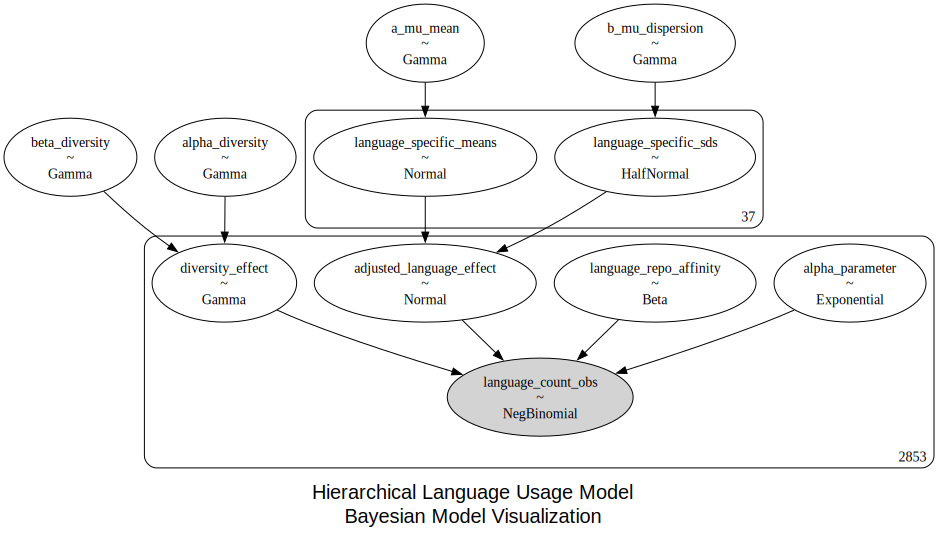

In [37]:
# Assuming 'language_usage_model' is your PyMC model
model_graph = pm.model_to_graphviz(language_usage_model)

# Customize the graph - Example changes
model_graph.attr(label='Hierarchical Language Usage Model\nBayesian Model Visualization')
model_graph.attr(fontsize='20', color='blue', fontname="Helvetica")

# Node and Edge customizations
with model_graph.subgraph() as s:
    s.attr(rank='same')
    # Customize nodes
    s.node_attr.update(color='lightblue2', style='filled', fontname="Helvetica")
    # Customize edges
    s.edge_attr.update(color='gray', arrowsize='0.5')

# Render the graph 
model_graph


In [38]:
# Fiting the model - using nutpie for faster sampling
# Im using nutpie here as i dont have a gpu available -> change to take advantage.

with language_usage_model:
    trace = pm.sample(1000, tune=500, return_inferencedata=True, nuts_sampler="nutpie")

C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1029: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1029: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\nutpie\compile_pymc.py:400: NumbaWarning: Cannot cache compiled function "numba_funcified_fgraph" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  return inner(x)


ValueError: Sampling failed: All initialization points failed

Caused by:
    Logp function returned error: Logp function returned error code 1

## Model Diagnostics
 - Checking model convergence (e.g., trace plots, R-hat statistics)
Posterior predictive checks


In [ ]:
#Summary stats for the language.
print(az.summary(trace, var_names="language_effect"))
az.plot_posterior(trace, var_names=["language_effect"])

# Plotting
axes = az.plot_forest(
    trace,
    kind='ridgeplot',
    var_names=["language_effect"],
    figsize=(10, 10),
    combined=True,
    ridgeplot_overlap=3,
    colors="cycle",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
)

# Assuming the first (or only) axis corresponds to the 'language_effect' variable
axes[0].set_yticklabels(language_to_code_sorted)


##  Results and Interpretation
- Extracting and summarizing the posterior distributions of model parameters
- Identifying significant factors and their impacts on language usage risk metrics
- Ridge plots for visualizing the distribution of language usage across projects and repositories, highlighting potential outliers or risks
- Additional plots for deeper insights (e.g., comparison of language usage trends across different organizational levels)

#### Key Considerations:

- **Credible Intervals and Outliers**: Narrow credible intervals suggest high parameter estimate certainty, while wide intervals indicate areas needing further investigation. Outlier detection can pinpoint innovative areas or non-standard practices for strategic exploration.

- **Decision-Making**: Insights from the HBM should inform strategic decisions regarding technology adoption, project management, and training to align coding practices with organizational goals, enhancing project continuity and adaptability.

This combined understanding of HBM principles, model structure, and practical implications equips readers with the knowledge to interpret complex data analyses meaningfully, driving informed decision-making within the organisation.

## PRedicitons

In [ ]:
# Example setup for a new repository with Lua and a specific byte count

#Its a new repo so just make the max + 1 
new_repo_index = df['Unique_Repo_codes'].max() + 1
# Get language Code
lua_language_code = df[df['Language'] == 'Lua']['Language_codes'].unique()[0]
print(lua_language_code)

In [ ]:
# Example setup for a new repository with Lua and a specific byte count

new_repo_data = {
    'repository_idx': np.array([new_repo_index]), 
    'languages_idx': np.array([lua_language_code]),  # Replace with the encoded index for Lua
    'byte_count': np.array([50000000]),  # Byte count for the new repo with Lua
}

# Adjust your model to include predictions for the new data
with language_usage_model:
    # Generate predictions
    pp_samples = pm.sample_posterior_predictive(
        trace,
        var_names=['language_count_obs'],
        data=new_repo_data
    )

# Analyze the predictive samples for the new repository
